# Lab Assignment 2 Notebook 2

## Andrew Marquardt

Question 3

In [363]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.integrate import solve_ivp
from scipy.optimize import least_squares

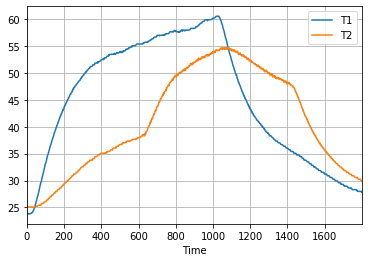

In [364]:
# import .csv file
data = pd.read_csv('data_lab_2.csv')
data.index = data['Time']
# check that data is intact
# note: I collected until 1800 seconds; equilibrium was not reached, but I am able to observe some cooling behavior
data[['T1','T2']].plot(grid=True)
plt.show()

t = [0,620] fit for T1:

In [365]:
def plot_data(expt, pred,xlimit):
    t_expt = expt.index
    
    # create a 3 x 1 grid of plot axes
    fig, ax = plt.subplots(3, 1, figsize=(10,8))
    
    # first plot axes
    ax[0].plot(t_expt, expt["T1"], label="T1 expt")
    ax[0].plot(t_expt, expt["T2"], label="T2 expt")
    ax[0].plot(t_expt, pred["T1"], label="T1 pred")
    ax[0].plot(t_expt, pred["T2"], label="T2 pred")
    ax[0].set_ylabel("deg C")
    ax[0].set_xlim(0,xlimit)
    ax[0].set_title("temperature response")
    
    # second plot axes
    ax[1].scatter(t_expt, expt["Q1"], label="Q1 expt")
    ax[1].scatter(t_expt, expt["Q2"], label="Q2 expt")
    ax[1].plot(t_expt, pred["Q1"], label="Q1 pred")
    ax[1].plot(t_expt, pred["Q2"], label="Q2 pred")
    ax[1].set_ylim([0, 100])
    ax[1].set_xlim(0,xlimit)
    ax[1].set_ylabel("percent")
    ax[1].set_title("heater power")
    
    # third plot axes
    ax[2].plot(t_expt, pred["T1"]-expt["T1"], label="T1 error")
    ax[2].plot(t_expt, pred["T2"]-expt["T2"], label="T1 error")
    ax[2].set_xlim(0,xlimit)
    ax[2].set_title("residuals")
      
    # things to do for every plot axes
    for a in ax:
        a.grid(True)
        a.set_xlabel("time / seconds")
        a.legend()
        
    plt.tight_layout()
    
    return

Residual sum: 88.57716082432125


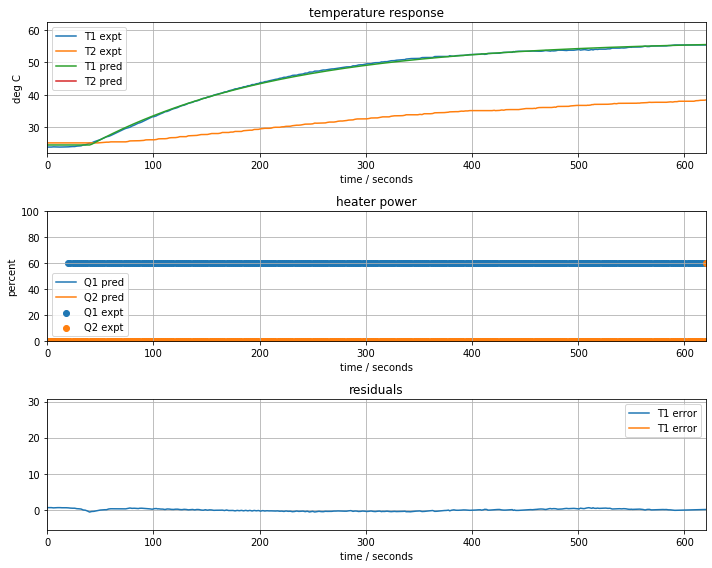

In [366]:
# parameter values and units
T_amb = (23.799 + 25.088)/2  # deg C; taken from average of T1(t=0) and T2(t=0)
u1bar = data["Q1"].mean()
t_expt = data.index

# adjustable parameters
K = 0.9605
tau = 181.33
t_delay = 40.74

def model_first_order_delay(param, plot=False):
    K, tau, t_delay = param    
    pred = pd.DataFrame(columns=["T1", "T2", "Q1", "Q2"], index=t_expt)
    pred["T1"] = [T_amb + K*u1bar*(1 - np.exp(-(t-t_delay)/tau)) if t > t_delay else T_amb for t in t_expt]
    if plot:
        plot_data(data, pred,620)
    T1_e = data["T1"].values
    T1_p = pred["T1"].values
    return T1_e,T1_p
T1_e,T1_p = model_first_order_delay([K, tau, t_delay], True)
resid = abs(T1_e - T1_p)
sum_resid = 0
for i in range(339):
    sum_resid += resid[i]
print("Residual sum: " + str(sum_resid))

In [373]:
print("System time constant: " + str(tau) + " seconds.")
print("System time delay: " + str(t_delay) + " seconds.")
alpha = 0.00016
P1 = 200
P2 = 100
u1 = 60
u2 = 0
sys_gain = 60*P1*alpha
sys_gain_T = (55.381 - 23.799)/60
print("System gain: " + str(sys_gain) + " Watts.")
print("In terms of temperature per heater power increase:")
print("System gain: " + str(sys_gain_T) + " degrees C per percent heater power increase.")

System time constant: 181.33 seconds.
System time delay: 40.74 seconds.
System gain: 1.9200000000000002 Watts.
In terms of temperature per heater power increase:
System gain: 0.5263666666666666 degrees C per percent heater power increase.


Fourth Order Model Fit

array([ 0.6445    ,  0.6445    ,  0.6445    , ..., -1.55241581,
       -1.55047302, -1.54885489])

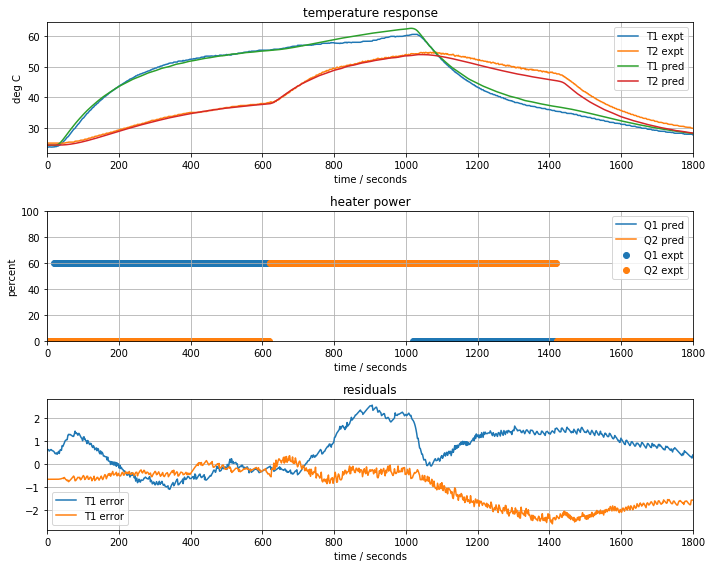

In [369]:
# adjustable parameters
CpH = 5                # joules/deg C
CpS = 1                # joules/deg C
Ua = 0.05              # watts/deg C
Ub = 0.05              # watts/deg C
Uc = 0.05              # watts/deg C

def model_energy_fourth_order(param, plot=False):
    # unpack the adjustable parameters
    CpH, CpS, Ua, Ub, Uc = param  
    
    # heater functions
    def u1(t):
        if t < 20:
            U1 = 0
        elif t >= 20 and t < 1020:
            U1 = 60
        elif t >= 1020:
            U1 = 0
        return U1

    def u2(t):
        if t < 620:
            U2 = 0
        elif t >= 620 and t < 1420:
            U2 = 60
        elif t >= 1420:
            U2 = 0
        return U2
    
    # model solution
    def deriv(t, y):
        T1H, T1S, T2H, T2S= y
        dT1H = (-(Ua + Ub + Uc)*T1H + Ub*T1S + Uc*T2H + alpha*P1*u1(t) + Ua*T_amb)/CpH
        dT1S = Ub*(T1H - T1S)/CpS
        dT2H = (-(Ua + Ub + Uc)*T2H + Ub*T2S + Uc*T1H + alpha*P2*u2(t) + Ua*T_amb)/CpH
        dT2S = Ub*(T2H - T2S)/CpS
        return [dT1H, dT1S, dT2H, dT2S]

    soln = solve_ivp(deriv, [min(t_expt), max(t_expt)], [T_amb]*4, t_eval=t_expt) 
    
    # create dataframe with predictions
    pred = pd.DataFrame(columns=["T1", "T2", "Q1", "Q2"], index=t_expt)
    pred["T1"] = soln.y[1]
    pred["T2"] = soln.y[3]

    # plot solution
    if plot:
        ax = plot_data(data, pred,1800)
    
    err1 = np.array(pred["T1"] - data["T1"])
    err2 = np.array(pred["T2"] - data["T2"])
    
    return np.concatenate((err1, err2))
    
results = least_squares(model_energy_fourth_order,  [CpH, CpS, Ua, Ub, Uc])
CpH, CpS, Ua, Ub, Uc = results.x
model_energy_fourth_order(results.x, True)

In [372]:
print("CpH: " + str(results.x[0]) + " Joules/degree C")
print("CpS: " + str(results.x[1]) + " Joules/degree C")
print("Ua: " + str(results.x[2]) + " Watts/degree C")
print("Ub: " + str(results.x[3]) + " Watss/degree C")
print("Uc: " + str(results.x[4]) + " Watts/degree C")

CpH: 8.570225192333513 Joules/degree C
CpS: 1.1198465579234749 Joules/degree C
Ua: 0.03916910667788763 Watts/degree C
Ub: 0.08256218948251515 Watss/degree C
Uc: 0.03558351485126857 Watts/degree C
